<a href="https://colab.research.google.com/github/srg9000/adlink-2020-vision-hack/blob/main/Adlink_OpenVINO_APT_installer_TensorFlow_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial demostrates step-by-step instructions to perform inference on a [Tensorflow-Keras model](https://keras.io/api/applications/inceptionv3/) using [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download).

![one page](https://drive.google.com/uc?id=1cX0U1lQFnQ-_0qYNHx4dCDpgfX5FBDi7)


#Install OpenVINO

##Download and Install OpenVINO Toolkit (APT Method)

In [1]:
print("This will take a while...")
!wget -O openvino_key https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691&erpm_id=9830841_ts1607381885691&elq_cid=6770273_ts1607381960247&erpm_id=9830841_ts1607381960247 
!apt-key add openvino_key
#!apt-key -q list
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" | tee /etc/apt/sources.list.d/intel-openvino-2021.list
!apt update -q
!apt-get install intel-openvino-dev-ubuntu18-2021.1.110 -y -q
!pip install -U --no-deps --quiet openvino

#unknown bug - this is just a patch
!cp /opt/intel/openvino_2021.1.110/deployment_tools/inference_engine/external/tbb/lib/libtbb.so /usr/lib/x86_64-linux-gnu/libtbb.so
!cp /opt/intel/openvino_2021.1.110/deployment_tools/inference_engine/external/tbb/lib/libtbb.so.2 /usr/lib/x86_64-linux-gnu/libtbb.so.2
!ldconfig
print("Installation Completed...")
#%env we can set environmental variable with this


This will take a while...
--2020-12-25 15:21:14--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691
Resolving apt.repos.intel.com (apt.repos.intel.com)... 104.79.147.193, 2600:1406:3f:a95::4b23, 2600:1406:3f:a90::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|104.79.147.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘openvino_key’

openvino_key        100%[===================>]     939  --.-KB/s    in 0s      

2020-12-25 15:21:14 (44.6 MB/s) - ‘openvino_key’ saved [939/939]

OK
deb https://apt.repos.intel.com/openvino/2021 all main
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.

## Run Validation Demo

In [2]:
#Run the Validation Demo code.
demo_cmd = "/opt/intel/openvino_2021/deployment_tools/demo/demo_squeezenet_download_convert_run.sh"
import os
import subprocess
import shutil
output = subprocess.check_output(demo_cmd, shell=True)
print (output.decode('utf-8'))     

target_precision = FP16
[setupvars.sh] OpenVINO environment initialized


###################################################



Installing dependencies
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://apt.repos.intel.com/openvino/2021 all InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-update

# OpenVINO Tensorflow Demos

## Image Classification (InceptionV3) 

###Import the Tensorflow Library and InceptionV3

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

import shutil
import subprocess

###Download the InceptionV3 (imagenet) Model

In [4]:
print("Downloading the model....")
model = InceptionV3(weights='imagenet')
model_fname = './inceptionv3'

# Save the model to path specified.
if os.path.isdir(model_fname):
    print(f"{model_fname} exists already. Deleting the folder")
    shutil.rmtree(model_fname)
os.mkdir(model_fname)

# Save the model
print("\nSaving the model in Tensorflow SavedModel Format ...")
model.save(model_fname)
print(f"Model saved at {model_fname}")

96116736/96112376 [==============================] - 1s 0us/step

Saving the model in Tensorflow SavedModel Format ...
INFO:tensorflow:Assets written to: ./inceptionv3/assets
Model saved at ./inceptionv3


### Convert the Model to IR

In [5]:
source_cmd= "/opt/intel/openvino_2021/bin/setupvars.sh"

# Setup model optimizer command ...
ir_name = "inceptionv3"
ir_data_type = "FP32"
ir_out_dir = f"{model_fname}/IR_models/{ir_data_type}"
ir_input_shape = "[1,299,299,3]"

mo_cmd = f"/opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py \
      --saved_model_dir {model_fname} \
      --input_shape {ir_input_shape} \
      --data_type {ir_data_type} \
      --output_dir {ir_out_dir}  \
      --model_name {ir_name}"
print ("Running model optimizer to convert model to OpenVINO IR format ....")
print("\n--".join(mo_cmd.split("--")))

output = subprocess.check_output(source_cmd+" && "+mo_cmd, shell=True)
print (output.decode('utf-8'))     

Running model optimizer to convert model to OpenVINO IR format ....
/opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py       
--saved_model_dir ./inceptionv3       
--input_shape [1,299,299,3]       
--data_type FP32       
--output_dir ./inceptionv3/IR_models/FP32        
--model_name inceptionv3
[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/content/./inceptionv3/IR_models/FP32
	- IR output name: 	inceptionv3
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,299,299,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None


###Define Preprocessing Function

In [6]:
#install pre-req
!pip install pillow numpy -q

from PIL import Image
import numpy as np

def pre_process_image(imagePath, img_height=299):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Normalize to keep data between 0 - 1
    image = np.array(image) / 255.0

    # Change data layout from HWC to CHW
    image = image.transpose((2, 0, 1))
    input_image = image.reshape((n, c, h, w))

    return input_image

### Download, Load and Pre-process the Input Image

---




In [7]:
inp_img_url = "https://i.pinimg.com/236x/20/e9/f7/20e9f7a52bcf241c79a48510562c71e9.jpg"
inp_file_name = 'dog-image.jpg'

#Download the image from wikipedia
output = subprocess.check_output(f"curl {inp_img_url} --output {inp_file_name}", shell=True)

#Pre-process the image and get it ready for inference.
input_image = pre_process_image(inp_file_name)

### Load the OpenVINO IR network and Run the Inference

In [8]:
from openvino.inference_engine import IECore

model_xml = f'{ir_out_dir}/{ir_name}.xml'
model_bin = f'{ir_out_dir}/{ir_name}.bin'

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")
del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

# Run the Inference on the Input image...
res = exec_net.infer(inputs={input_layer: input_image})
res = res[output_layer]

### Process and Display the Results

40960/35363 [==================================] - 0s 0us/step
Top 3 Predictions:
pug: 74.38 %
Brabancon_griffon: 1.47 %
bull_mastiff: 0.74 %
Prediction: pug: 74.38 %


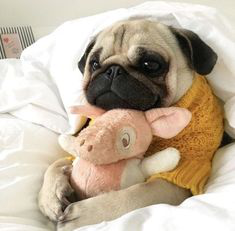

In [9]:
from tensorflow.keras.applications.inception_v3 import decode_predictions
# Predicted class index.
idx = np.argsort(res[0])[-1]
top3_pred = decode_predictions(res, top=3)[0]

print('Top 3 Predictions:')
for pred in top3_pred:
    print(f"{pred[1]}: {pred[2]*100 :.2f} %")
    
#Display the result on screen
from IPython.display import display 
pred_class = top3_pred[0][1]
pred_prob = top3_pred[0][2]
print(f"Prediction: {pred_class}: {pred_prob*100:.2f} %")
display(Image.open(inp_file_name))

## Tensorflow Comparison

### Download, Load, and Preprocess, and Run Inference the Input Image

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions

model = InceptionV3(weights='imagenet')

inp_img_url = "https://i.pinimg.com/236x/20/e9/f7/20e9f7a52bcf241c79a48510562c71e9.jpg"
inp_file_name = 'dog-image.jpg'

#Download the image from wikipedia
output = subprocess.check_output(f"curl {inp_img_url} --output {inp_file_name}", shell=True)

img = image.load_img(inp_file_name, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x, mode='tf')

preds = model.predict(x)

###Display Results

Top 3 Predictions:
pug: 76.90 %
Brabancon_griffon: 0.78 %
bull_mastiff: 0.61 %
Prediction: pug: 76.90 %


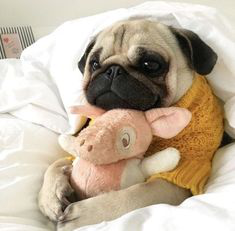

In [11]:
from tensorflow.keras.applications.inception_v3 import decode_predictions
# Predicted class index.
idx = np.argsort(preds[0])[-1]
top3_pred = decode_predictions(preds, top=3)[0]

print('Top 3 Predictions:')
for pred in top3_pred:
    print(f"{pred[1]}: {pred[2]*100 :.2f} %")

from IPython.display import display 
pred_class = top3_pred[0][1]
pred_prob = top3_pred[0][2]
print(f"Prediction: {pred_class}: {pred_prob*100:.2f} %")
display(Image.open(inp_file_name))

# References:

Intel OpenVINO Toolkit:
* https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html

Google COLAB Limitations:
* https://research.google.com/colaboratory/faq.html#resource-limits

Intel DevCloud: 
* https://devcloud.intel.com/edge/
